In [139]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import statistics

In [84]:
# Add path of your data on your local drive

df = pd.read_csv("train.csv")

In [85]:
# Clean input dataframe

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

# Create minute column
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['dropoff_minutes'] = df['dropoff_datetime'].dt.minute

# Create hour column
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

# Create day of week column
df['pickup_dow'] = df['pickup_datetime'].dt.weekday
df['dropoff_dow'] = df['dropoff_datetime'].dt.weekday

# Create day of month column
df['pickup_dom'] = df['pickup_datetime'].dt.day
df['dropoff_dom'] = df['dropoff_datetime'].dt.day

# Create month column
df['pickup_month'] = df['pickup_datetime'].dt.month
df['dropoff_month'] = df['dropoff_datetime'].dt.month

# Map 'Y' and 'N' in 'store_and_fwd_flag' as 1 and 0
store_and_fwd_map = {'Y':1,'N':0}
df = df.copy()
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(store_and_fwd_map)

In [86]:
# Create missing data
random.seed(123)

# Insert nan values in pickup_hour
nan_pickup_hours = df['pickup_hour'].sample(round(df.shape[0]/21)).index
df.loc[nan_pickup_hours,'pickup_hour']=np.nan

# Insert nan values in dropoff_longitude
nan_dropoff_longitude = df['dropoff_longitude'].sample(round(df.shape[0]/17)).index
df.loc[nan_dropoff_longitude,'dropoff_longitude']=np.nan

In [140]:
# Approach 1 - Delete rows with missing values
# Pass only the dataframe as argument

def approach1_rem_msg(messy_df):
    clean_df = messy_df.dropna()
    return clean_df

#------------------------------------------------------------------------------------------------------------------------

# Approach 2 - Impute missing values
# The following function imputes the missing values with mean/median/mode according to arguments passed
# User also has to pass as list the names of columns which have missing values 
# Call function  - approach2_impute_metric(<df>,<"mean">/<"median">/<"mode">,[<'missingcolname1'>,<'missingcolname2'])

def approach2_impute_metric(messy_df, metric, colnames):
    clean_df = messy_df.copy()
    if metric=="mean":
        for col in colnames:
            imputenum = messy_df[col].mean()
            clean_df[col] = messy_df[col].fillna(imputenum)
            
    if metric=="median":
        for col in colnames:
            imputenum = messy_df[col].median()
            clean_df[col] = messy_df[col].fillna(imputenum)
            
    if metric=="mode":
        for col in colnames:
            imputenum = statistics.mode(messy_df[col])
            print(imputenum)
            clean_df[col] = messy_df[col].fillna(imputenum)
    
    return clean_df
 
#-------------------------------------------------------------------------------------------------------------------------

# Approach 3 - Predict missing values
    
def approach3_predict_msg(messy_df, metric, colnames):
    
    X_df = messy_df.drop(colnames, axis = 1)
    Y_df = messy_df[colnames]
    Y_pred_df = pd.DataFrame(columns=colnames)
    
    for col in messy_df[colnames]:
    
        messy_df_train = messy_df[~messy_df[col].isnull()]
        msg_cols_train_df = messy_df_train[col]
        messy_df_train = messy_df_train.drop(colnames, axis = 1)

        messy_df_test = messy_df[messy_df[col].isnull()]
        msg_cols_test_df = messy_df_test[col]
        messy_df_test = messy_df_test.drop(colnames,axis = 1)

        Y_train = msg_cols_train_df.copy()
        X_train = messy_df_train.copy()
        
        if metric == "Linear Regression":
            model = LinearRegression()
            model.fit(X_train,Y_train)
            print("R-squared value is: " + str(model.score(X_train, Y_train)))
            
        elif metric == "Random Forests":
            model = RandomForestRegressor(n_estimators = 100 , oob_score = True)
            model.fit(X_train,Y_train) 
        
       
        
        X_test = messy_df_test.copy()
        Y_test = model.predict(X_test)
        
        Y_test_integer = pd.to_numeric(pd.Series(Y_test),downcast='integer')
        Y_complete = Y_train.append(Y_test_integer)
        Y_complete = Y_complete.reset_index(drop = True)
        
        Y_pred_df[col] = Y_complete
        Y_pred_df = Y_pred_df.reset_index(drop = True)
   
    clean_df = X_df.join(Y_pred_df)
    
    return clean_df

In [131]:
def accuracy_determination(df,algo, Y_col):
    y = df[Y_col]
    X = df.drop(Y_col, axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    if algo == "Logistic Regression":
        model = LogisticRegression()
        model.fit(X_train,y_train)
    elif algo == "Random Forests":
        model = RandomForestClassifier(n_estimators = 100 , oob_score = True)
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [141]:
# Test the approaches to missing data

df_test = df.drop(['id','pickup_datetime','dropoff_datetime','trip_duration'], axis = 1)
df_test = df_test.head(1000)

# Call function to clean missing data

# Approach 1 - delete rows containing missing values 
test_pred1 = approach1_rem_msg(df_test)

# Approach 2 - Impute with mean/median/mode
test_pred2a = approach2_impute_metric(df_test,"mean",['dropoff_longitude','pickup_hour'])
test_pred2b = approach2_impute_metric(df_test,"median",['dropoff_longitude','pickup_hour'])
test_pred2c = approach2_impute_metric(df_test,"mode",['dropoff_longitude','pickup_hour'])

# Approach 3 - Predict missing value
test_pred3a = approach3_predict_msg(df_test,"Linear Regression",['dropoff_longitude','pickup_hour'])
test_pred3b = approach3_predict_msg(df_test,"Random Forests",['dropoff_longitude','pickup_hour'])

-73.994430542
18.0
R-squared value is: 0.180327865846
R-squared value is: 0.988181052827


In [142]:
test_pred2c['pickup_hour']

0      17.0
1       0.0
2      11.0
3      19.0
4      13.0
5      18.0
6      22.0
7       7.0
8      23.0
9      21.0
10     22.0
11     11.0
12      9.0
13     20.0
14      0.0
15     15.0
16     17.0
17      8.0
18      9.0
19     13.0
20     18.0
21     12.0
22      3.0
23     10.0
24      8.0
25     13.0
26     21.0
27     23.0
28     21.0
29     14.0
       ... 
970    21.0
971    22.0
972    21.0
973    18.0
974     0.0
975    19.0
976    18.0
977    11.0
978    14.0
979     5.0
980    20.0
981    17.0
982    18.0
983    19.0
984    11.0
985    15.0
986     5.0
987     0.0
988    18.0
989     7.0
990     9.0
991     0.0
992     8.0
993    10.0
994    13.0
995    10.0
996     2.0
997    11.0
998    16.0
999    21.0
Name: pickup_hour, Length: 1000, dtype: float64

In [ ]:
# Compare missing value replacement approaches 

In [ ]:
df2 = df.loc[:100000,:]
trip_duration_cutoff_mins = 20
df2['trip_duration_encoded'] = 0
df2.loc[df2['trip_duration']>=trip_duration_cutoff_mins*60,'trip_duration_encoded'] = 1
df2.loc[df2['trip_duration']<trip_duration_cutoff_mins*60,'trip_duration_encoded'] = 0
df2 = df2.drop(['id','pickup_datetime','dropoff_datetime','dropoff_minutes','dropoff_hour',
                'dropoff_dow','dropoff_dom','dropoff_month','trip_duration','dropoff_longitude','dropoff_latitude'], axis = 1)
df2.dropna(inplace=True);

In [ ]:
import time
a = time.time()

logistic_accuracy = accuracy_determination(df2,"Logistic Regression",'trip_duration_encoded')
print(logistic_accuracy)
rf_accuracy = accuracy_determination(df2,"Random Forests",'trip_duration_encoded')

print(rf_accuracy)
print(time.time()-a)

In [ ]:
import missingno as msno
msno.matrix(df)

In [ ]:
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output

# make 4 buttons
button1 = Button(description="Delete rows with missing values",
           layout=Layout(width='50%', height='50px'),)
button2 = Button(description="Impute metric: Mean",
                layout=Layout(width='50%', height='50px'))
button3 = Button(description="Impute metric: Median",
                layout=Layout(width='50%', height='50px'))
button4 = Button(description="Impute metric: Mode",
                layout=Layout(width='50%', height='50px'))
button5 = Button(description="Predict values: Linear Regression",
                layout=Layout(width='50%', height='50px'))
button6 = Button(description="Predict values: Random Forests",
                layout=Layout(width='50%', height='50px'))
display(button1, button2, button3, button4, button5, button6)

# define button calls

def button1Clicked(b):
    clear_output()
    msno.matrix(test_pred1)
    
def button2Clicked(b):
    clear_output()
    display(test_pred2)
    
def button3Clicked(b):
    clear_output()
    display(test_pred3)
        
def button4Clicked(b):
    clear_output()
    display(test_pred4)
    
# specify which functions to be called when buttons are clicked
button1.on_click(button1Clicked)
button2.on_click(button2Clicked)
button3.on_click(button3Clicked)
button4.on_click(button4Clicked)

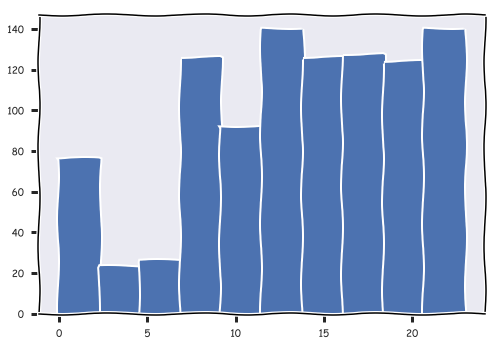

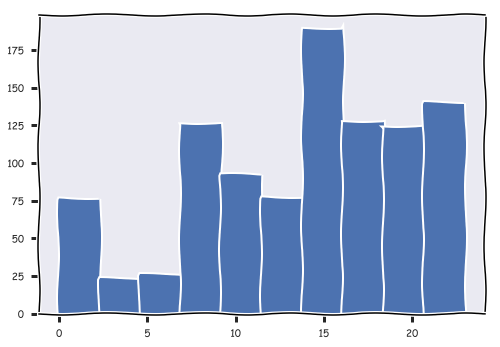

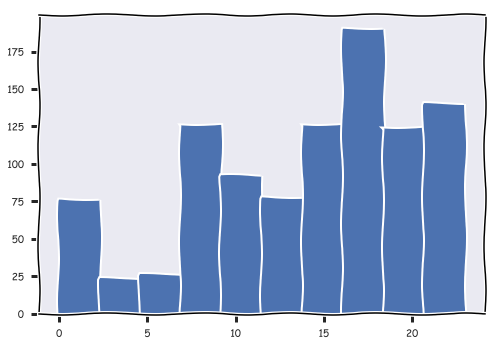

In [145]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(test_pred2a['pickup_hour'])
plt.show()

plt.hist(test_pred2b['pickup_hour'])
plt.show()

plt.hist(test_pred2c['pickup_hour'])
plt.show()

In [ ]:
plt.hist(test_pred2a['pickup_hour'])

fig = plt.gcf()

plot_url = py.plot_mpl(fig, filename='mpl-basic-histogram')

In [ ]:
# Test code below - Do not run 6,7,10,16,17

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
character_cols = ['Origin','UniqueCarrier','Dest']

for col in character_cols:
    le.fit(X[col].values)
    X[col]=le.transform(X[col])

In [ ]:
sum(Y==1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 10 , oob_score = True)
model.fit(X,Y)

In [ ]:
model_features = pd.Series(model.feature_importances_,X.columns)
model_features.sort_values
model_features.plot(kind="barh",figsize=(7,6))

In [ ]:
model.feature_importances_